# Portfolio Risk Assessment & 1-Day 95% VaR (Value At Risk) Calculation

## A small investment firm needs to quantify the daily risk of its equity portfolio.

## Key Learnings
1. Pull Historical Price Data for a list of tickers.
2. Compute Daily log-returns and summary statistics (mean, variance, skewness, kurtosis).
3. Fit Normal & Student's t distribution to returns.
4. Build 95% Confidence Intervals for the mean return and volatility.
5. Compute 1-Day 95% VaR parametrically (Normal & t) and via historical simulation.
6. Test whether the mean return is significantly different from zero.

## Project Overview
### Goal: Quantify the daily risk of losing money in a simple four-stock portfolio.

In [1]:
!pip install --quiet yfinance
!pip install pandas_datareader

   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   -- ------------------------------------- 0.3/3.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.5/3.8 MB 799.2 kB/s eta 0:00:05
   ----- ---------------------------------- 0.5/3.8 MB 799.2 kB/s eta 0:00:05
   -------- ------------------------------- 0.8/3.8 MB 819.2 kB/s eta 0:00:04
   -------- ------------------------------- 0.8/3.8 MB 819.2 kB/s eta 0:00:04
   ----------- ---------------------------- 1.0/3.8 MB 762.8 kB/s eta 0:00:04
   ------------- -------------------------- 1.3/3.8 MB 762.6 kB/s eta 0:00:04
   ------------- -------------------------- 1.3/3.8 MB 762.6 kB/s eta 0:00:04
   ------------- -------------------------- 1.3/3.8 MB 762.6 kB/s eta 0:00:04
   ---------------- ----------------------- 1.6/3.8 MB 660.6 kB/s eta 0:00:04
   ---------------- ----------------------- 1.6/3.8 MB 660.6 kB/s eta 0:00:04
   ----------

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import seaborn as sns
import datetime as dt
from scipy import stats
import time

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
weights = np.array([0.25, 0.25, 0.25, 0.25])

start = dt.datetime(2020, 1, 1)
end = dt.datetime.today()

prices = pd.DataFrame() #index = pd.date_range(start,end)

for ticker in tickers:
  print(f"Fetching {ticker}...", end = " ")
  try:
    df = yf.Ticker(ticker).history(
        start = start.strftime('%Y-%m-%d'),
        end = end.strftime('%Y-%m-%d'),
        auto_adjust = True,
    )
    series = df['Close']
    print("✔️ yfinance", end = "")
  except Exception as e:
    print(f" ❌yfinance ({e}); falling back to Stooq", end = "")
    df2 = pdr.DataReader(ticker, 'stooq', start, end)
    df2 = df2.sort_index()
    series = df2['Close']
  prices[ticker] = series
  time.sleep(1)
  print()

prices = prices.dropna(how = 'all').ffill().bfill()

print(prices.tail())

Fetching AAPL... ✔️ yfinance
Fetching MSFT... ✔️ yfinance
Fetching GOOGL... ✔️ yfinance
Fetching AMZN... ✔️ yfinance
                                 AAPL        MSFT       GOOGL        AMZN
Date                                                                     
2025-06-25 00:00:00-04:00  201.559998  492.269989  170.679993  211.990005
2025-06-26 00:00:00-04:00  201.000000  497.450012  173.539993  217.119995
2025-06-27 00:00:00-04:00  201.080002  495.940002  178.529999  223.300003
2025-06-30 00:00:00-04:00  205.169998  497.410004  176.229996  219.389999
2025-07-01 00:00:00-04:00  207.820007  492.049988  175.839996  220.460007


In [3]:
logR = np.log(prices / prices.shift(1)).dropna()
logR.head()

,AAPL,MSFT,GOOGL,AMZN
Date,,,,
2020-01-03 00:00:00-05:00,-0.009770,-0.012530,-0.005245,-0.012213
2020-01-06 00:00:00-05:00,0.007937,0.002581,0.026305,0.014776
2020-01-07 00:00:00-05:00,-0.004714,-0.009159,-0.001934,0.002089
2020-01-08 00:00:00-05:00,0.015958,0.015803,0.007092,-0.007839
2020-01-09 00:00:00-05:00,0.021019,0.012416,0.010443,0.004788


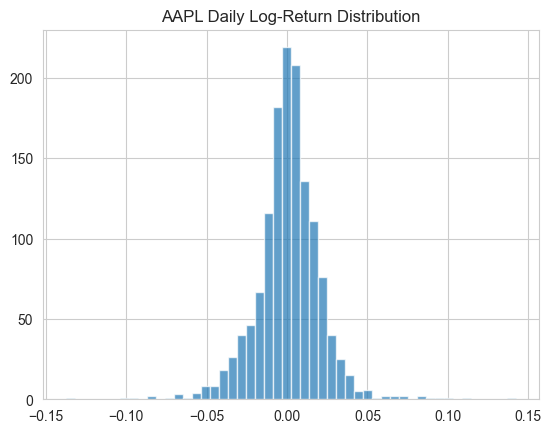

In [4]:
logR['AAPL'].hist(bins = 50, alpha = 0.7)
plt.title('AAPL Daily Log-Return Distribution')
plt.show()

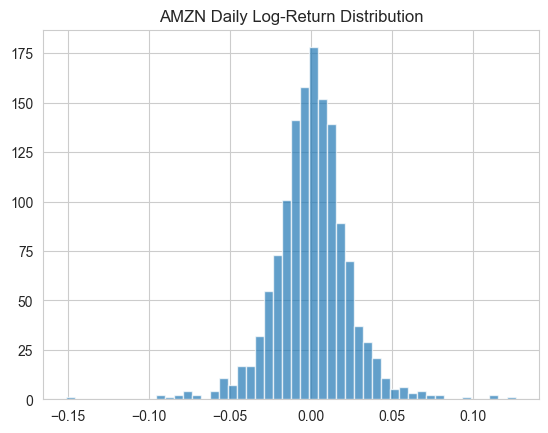

In [5]:
logR['AMZN'].hist(bins = 50, alpha = 0.7)
plt.title('AMZN Daily Log-Return Distribution')
plt.show()

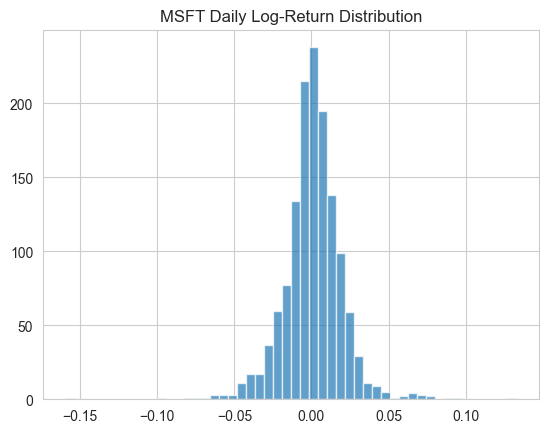

In [6]:
logR['MSFT'].hist(bins = 50, alpha = 0.7)
plt.title('MSFT Daily Log-Return Distribution')
plt.show()

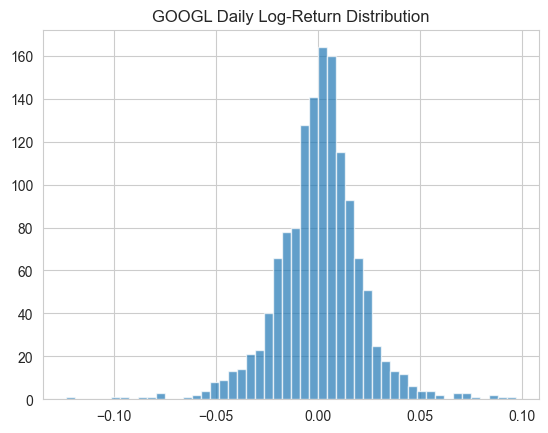

In [7]:
logR['GOOGL'].hist(bins = 50, alpha = 0.7)
plt.title('GOOGL Daily Log-Return Distribution')
plt.show()

## 3. Summary Statistics
Compute for each stock:
- Mean: Average Daily Return
- Variance: How much Returns Vary
- Skewness: Asymmetry (Positive Skew -> Fat Right Tail)
- Kurtosis: Tail-Heaviness (High Kurtosis -> More Extreme Days)

In [8]:
summary = pd.DataFrame({
    'Mean' : logR.mean(),
    'Variance' : logR.var(),
    'Skewness' : logR.skew(),
    'Kurtosis' : logR.kurtosis()
})
summary

,Mean,Variance,Skewness,Kurtosis
AAPL,0.000762,0.000420,0.019045,6.273746
MSFT,0.000846,0.000367,-0.170136,7.549115
GOOGL,0.000688,0.000428,-0.226074,3.624900
AMZN,0.000611,0.000518,-0.072094,4.200567


- Mean (≈0.05-0.0.8%): On Average, each stock's daily return was very small-about a few-tenths of a percent gain per day.
- Variance (≈0.0004): Typical daily swings are around √0.0004 ≃ 2%, so most days see moves of couple percent.
- Skewness (near zero or slightly negative): Returns are roughly symmetric, with a small tendency toward bigger down-moves than up-moves.
- Kurtosis (>3): All four have "fat tails", meaning they experience more extreme one-day jumps or crashes than a normal bell curve would predict.

## 4. Fit Parametric Distributions & 95% CIs

- First, We "stack" all individual stock return columns into one long array so we can fit a single Normal curve to every observed daily
  return, not just one asset at a time. Calling .mean() and .std(ddof=1) on that array then gives us the sample mean (µ) and unbiased sample
  standard deviation (ɑ) needed to parametrize our Normal Distribution.
- Then, we compute a 95% Confidence Interval for the true average return by using the fact that, under the Central Limit Theorem, the sample
  mean x is approximately normally distributed with standard error ɑ/√N.
- Here:
  - N = logR.size is the total number of return observations.
  - ɑ_norm: is our estimate of the true volatility (simple standard deviation).
  - z0.975 ≈ 1.96 is the critical value so that 95% of a standard normal lies between ± z0.975
  - Thus, the interval x ± z0.95 ɑ/√N tells us that we are 95% confident the true mean dialy return lies between those two bounds.
- Step 3 - In plain terms:
  - Degrees of freedom (N-1) reflect how many independent pieces of information we have for estimating variance.

In [9]:
mu_norm, sigma_norm = logR.stack().mean(), logR.stack().std(ddof = 1)

N = logR.size
z95 = stats.norm.ppf(0.975)
ci_mu_norm = (mu_norm - z95 * sigma_norm / np.sqrt(N),
              mu_norm + z95 * sigma_norm / np.sqrt(N))

df = N-1
chi2_low, chi2_high = stats.chi2.ppf([0.025, 0.975], df)
ci_sigma_norm = (sigma_norm*np.sqrt(df/chi2_high),
                 sigma_norm*np.sqrt(df/chi2_low))

print("Normal Fit:")
print(f" µ = {mu_norm:.5f}, 95% CI {ci_mu_norm}")
print(f" σ = {sigma_norm:.5f}, 95% CI {ci_sigma_norm}")

Normal Fit:
 µ = 0.00073, 95% CI (np.float64(0.00017791838319291035), np.float64(0.001275653305606034))
 σ = 0.02081, 95% CI (np.float64(0.020425040375568315), np.float64(0.021201577620479486))


- Average Daily Return (µ = 0.00065): This means the portfolio earned about 0.065% per day, on average. That's like earning 65 paisa per
  ₹1000 each day.
- Confidence Interval for µ (0.0095% to 0.1214%): We're 95% sure the average daily return is somewhere between 0.0095% and 0.1214%. The number
  might be a little lower or higher than our estimate, but it's likely within the range.
- Daily Volatility (ɑ = 0.02093): This means returns typically move up or down by about 2.093% each day. So, on any given day, you could gain
  or lose roughly ₹21 on a ₹1000 investment.
- Confidence Interval for ɑ (2.05% to 2.13%): We're 95% confident the real day-to-day movement lies between 2.05% and 2.13%. This helps us
  understand how "bumpy" the ride is.

In Step 4.1, we assumed that daily returns follow a Normal (bell-curve) distribution. But real-world financial returns often show:
- Fat Tails (more extreme jumps/drops than a normal curve allows)
- Slight skew (returns are not perfectly symmetric)

So, we add Step 4.2 to:
1. **Fit a Student's t-distribution**
   - It looks like a Normal curve but with heavier tails.
   - Better reflects real-world risk by allowing more big losses/gains.
2. **Use Bootstrap Confidence Intervals**
   - The math for confidence intervals under a t-distribution is messy.
   - Bootstraping gives us a practical way to estimate uncertainty around mean(µ) and volatility (ɑ) by resampling the data many times.

**In Simple Terms:** This step gives us a more realistic model of returns and a safer estimate of risk, especially when big suprises (crashes or spikes) matter.

In [10]:
returns_flat = logR.stack().values
df_t, mu_t, sigma_t = stats.t.fit(returns_flat)

In [ ]:
B = 1000
estimates = np.array([stats.t.fit(np.random.choice(returns_flat, size=N, replace=True))
                      for _ in range(B)])

ci_mu_t = np.percentile(estimates[:,1], [2.5, 97.5])
ci_sigma_t = np.percentile(estimates[:,2], [2.5, 97.5])

print("\nStudent t Fit:")
print(f" df = {df_t:.1f}, µ = {mu_t:.5f}, σ = {sigma_t:.5f}")
print(f"95% CI for µ (bootstrap): {ci_mu_t}")
print(f"95% CI for σ (bootstrap): {ci_sigma_t}")

### Student's t Fit Results:
- df = 3.7 (degrees of freedom)
  - This tells us how "fat" the tails of the curve are.
  - A lower number (like 3.7) means the model expects more extreme ups and downs than a normal bell curve.
  - Real-life returns often behave this way, so this model is more realistic.
- µ = 0.00103 (average return)
  - This means the average daily return is about 0.103% per day.
  - In money terms: If you invest ₹1000, you earn about ₹1.03 each day on average.
- ɑ = 0.01450 (Volatily or typical movement)
- This means that on a typical day, the return moves up or down by about 1.45%.
- In money terms: Your ₹1000 investment might go up or down by around ₹14.50 on most days.
### Confidence Intervals (95%)
- 95% CI for µ: [0.00056, 0.00149]
  - We are 95% confident that the true average daily return lies between 0.056a% and 0.149%.
  - It might not be exactly 0.013%, but it's probably somewhere in this range.
- 95% CI for ɑ: [0.01402, 0.01500]
  - We are 95% confident the true daily volatility lies between 1.402% and 1.500%.
  - This tells us how "bouncy" or risky the daily returns really are.

### Summary:
According to a realistic model that allows for big jumps, your portfolio earns around 0.1% per day, usually moves about ±1.45%, and this estimate is pretty reliable based on the bootstrap confidence ranges.

In [ ]:
portR = logR.dot(weights)

µ_p = portR.mean()
σ_p = portR.std(ddof=1)

z05 = stats.norm.ppf(0.05)
VaR_norm = - (μ_p + σ_p * z05)

In [ ]:
t05 = stats.t.ppf(0.05, df_t)
VaR_t = - (mu_t + sigma_t * t05) * 1

## Historical VaR (non-parametric):
portR: This is your portfolio's acutal daily return history.
np.percentile(portR, 5): This finds the 5th percentile - the return that's worse than 95% of all the other days.
In other words,
"What was the worst 5% daily return we actually saw in the past?"
### Summary:
"Look at all your past daily returns. Pick the one that's right at the bottom 5% - that's your Historical VaR."
### Example
If your worst 5% return was -2.4%, then:
hist_var = -(-2.4%) = 2.4%

So you can say:
"There a 95% chance  I won't lose more than 2.4% in a single day, based on my past performance."
### Why it's useful:
- It uses real past data, not any assumption about bell curves or distributions.
- It's called non-parametric because it doesn't assume any particular shape of data (like Normal or t-distribution).
- It's simple, realistic, and easy to understand - especially for non-finance beginners.

In [ ]:
hist_var = -np.percentile(portR, 5)

print("1-Day 95% VaR:")
print(f"Parametric (Normal): {VaR_norm:.5f}")
print(f"Parametric (Student's t): {VaR_t:.5f}")
print(f"Historical (5th percentile): {hist_var:.5f}")

Assumes returns follows a perfect bell curve (Normal Distribution).

# 6. Hypothesis Test: Is Mean Return ≠ 0?

### What is this step doing?
- We are asking a yes/no question:
- "Is the average daily return of the portfolio actually different from zero?
  - Or is it just random noise?"
- This is called a __Hypothesis Test__ - specifically, a one-sample t-test.

### Why is this important?
If the mean return is significantly above zero, it suggests your portfolio is earning money consistently (Not just by luck).
If it's not significantly different from zero, it means the small average you see might just be random ups and downs, not real profit.
### What value does it add?
1. Confidence in the return estimate:
   - You already know the average return (say, 0.065% per day).
   - But this test tells you if that number is meaningful or statistically uncertain.
2. Supports better decision-making:
   - If the test shows "yes, return ≠ 0" -> You can trust your portfolio is growing over time.
   - If the test shows "no, return = 0" -> Your portfolio might not be reliably profitable.
3. Adds Scientific Rigor:
   - It moves you from just looking at numbers to make a statistical conclusion.
   - You're not guessing - you're testing a hypothesis with p-value.
### In Simple Terms:
"The average looks positive - but is that real growth, or just by chance?". This step helps you statistically test that question and avoid false confidence.
### Summary
Step 6 tells you whether your portfolio's average return is likely real or just random - and that's a critical insight for any investor or analyst, even without a finance background.

### Goal:
We want to know:
- "Is the average daily return of the portfolio really different from 0? Or could this result just be random?"

In [15]:
t_stat, p_val = stats.ttest_1samp(portR, 0.0)
print("One-Sample t-Test On Portfolio Daily Returns:")
print(f" t-statistic = {t_stat:.3f}, p-value = {p_val}")

if p_val < 0.05:
    print(" -> Reject H0: Mean Return Is Significantly Different From Zero.")
else:
    print(" -> Fail To Reject H0: No Evidence Mean Return ≠ 0.")

One-Sample t-Test On Portfolio Daily Returns:
 t-statistic = 1.449, p-value = 0.14752755782029237
 -> Fail To Reject H0: No Evidence Mean Return ≠ 0.


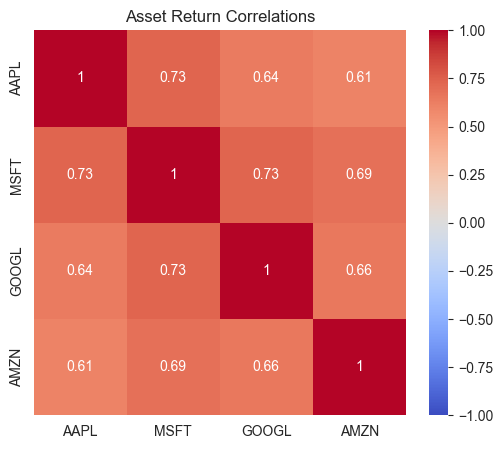

 Weighted Average σ: 0.0208
 Actual Portfolio σ: 0.0181
 Diversification Benefit:  0.0027


In [16]:
corr = logR.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title('Asset Return Correlations')
plt.show()

σ_i = logR.std()
σ_weighted = np.dot(weights, σ_i)
σ_portfolio = σ_p
print(f" Weighted Average σ: {σ_weighted:.4f}")
print(f" Actual Portfolio σ: {σ_portfolio:.4f}")
print(f" Diversification Benefit: {σ_weighted - σ_portfolio: .4f}")

Max Drawdown: -43.98%
 From 2021-12-10 To 2023-01-05


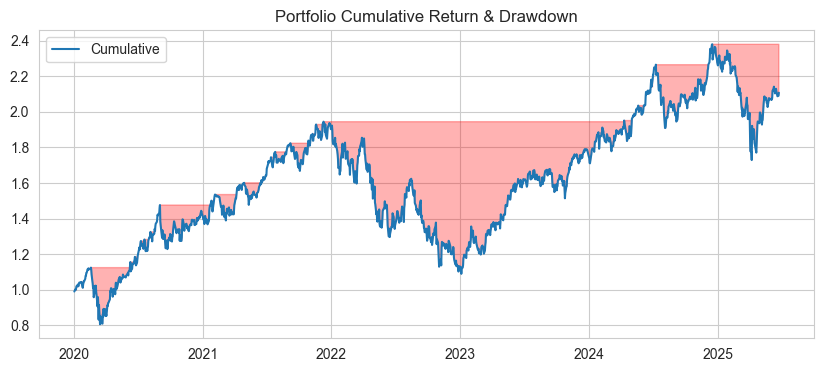

In [18]:
cum_ret = (prices / prices.iloc[0]).prod(axis=1)

cum_port = (portR + 1).cumprod()
rolling_max = cum_port.cummax()
drawdown = (cum_port - rolling_max) / rolling_max

max_dd = drawdown.min()
end_date = drawdown.idxmin()
start_date = cum_port[:end_date].idxmax()

print(f"Max Drawdown: {max_dd:.2%}")
print(f" From {start_date.date()} To {end_date.date()}")

plt.figure(figsize=(10,4))
plt.plot(cum_port, label = "Cumulative")
plt.fill_between(drawdown.index, cum_port, rolling_max,
                where = drawdown<0, color = 'red', alpha = 0.3)
plt.title('Portfolio Cumulative Return & Drawdown')
plt.legend()
plt.show()

In [19]:
alpha = 0.05
es_hist = -portR[portR <= np.percentile(portR, 5)].mean()
es_norm = -(µ_p - σ_p * stats.norm.pdf(z05) / alpha)

print(f"Historical ES (95%): {es_hist:.5f}")
print(f"Parametric Normal ES (95%): {es_norm:.5f}")

Historical ES (95%): 0.04210
Parametric Normal ES (95%): 0.03655


In [20]:
var_series = - (portR.rolling(1).mean() + portR.rolling(1).std()*z05)

exceptions = portR < -VaR_norm
num_exc = exceptions.sum()
total = len(portR)
print(f"Exceptions: {num_exc}/{total} days ({num_exc/total:.2%}, expected ~5%)")

Exceptions: 67/1375 days (4.87%, expected ~5%)


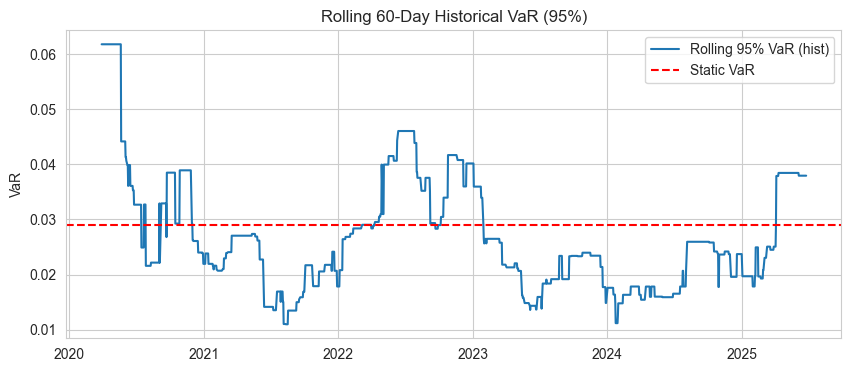

In [23]:
windows = 60
roll_var = portR.rolling(windows).quantile(0.05).dropna()
plt.figure(figsize = (10,4))
plt.plot(-roll_var, label = "Rolling 95% VaR (hist)")
plt.axhline(VaR_norm, color = 'red', linestyle = "--", label = 'Static VaR')
plt.title("Rolling 60-Day Historical VaR (95%)")
plt.ylabel("VaR")
plt.legend()
plt.show()

In [24]:
jb_stat, jb_p = stats.jarque_bera(portR)
print(f"JB Statistic: {jb_stat:.3f}, p-value: {jb_p:.3f}")
if jb_p < 0.05:
    print("Reject Normality at 5% Level")
else:
    print("Cannot Reject Normality")

JB Statistic: 1239.559, p-value: 0.000
Reject Normality at 5% Level
